### **Image Classification**

#### We will first see the dataset.

In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

In [ ]:
img = cv2.imread(r'.\dataset\Panda\Panda_29_1.jpg')

In [ ]:
img.shape

In [ ]:
plt.imshow(img)

In [ ]:
plt.axis("off")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()


In [ ]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray

In [ ]:
plt.axis("off")
plt.imshow(gray, cmap="grey")
plt.show()

1. **train/** – Where the Model Learns
Purpose: The model sees these images during training and adjusts its weights to minimize loss.

**Why**: We need a good chunk of data to teach the model what features distinguish a bear from a dog, a cat from a kangaroo.

**Rule**: Usually 70%–80% of the dataset goes here.

💡 Think of it like a student studying from their textbook.

2. **val/** – Where the Model is Watched
Purpose: Used to evaluate the model during training, after each epoch.

**Why**: Helps detect overfitting (when your model memorizes rather than learns) and guides adjustments like learning rate, regularization, or even architecture.

**Rule**: Usually 10%–15% of your data.

💡 Think of it like weekly quizzes—not part of final grading, but help steer the study plan.

3. **test/** – Where the Model is Judged
Purpose: Final evaluation of the trained model’s generalization ability.

**Why**: This is untouched data—never seen during training or validation—so it gives an honest picture of how your model will perform “in the wild.”

**Rule**: Around 10%–15% of the dataset.

💡 Think of it like the final exam. No peeking allowed.

> ~~

> ~~



#### **Step 1: creating the project structure**

In [ ]:
# import os

# folders = [
#     "data/raw", "data/processed/train", "data/processed/val", "data/processed/test",
#     "data/splits", "src", "notebooks", "app", "mlruns"
# ]

# for folder in folders:
#     os.makedirs(folder, exist_ok=True)


Copy your current dataset folder (with Bear, Cat, etc.) into `data/raw/`

#### **Step 2: Splitting the Raw data to train/val/test**

🧱 Split Dataset into train/, val/, and test/<br>
Now that all your class folders (like Bear/, Cat/, etc.) are safely inside data/raw/, we’ll distribute those images into:
```python
data/processed/
├── train/
├── val/
└── test/
```

Save the Script
In your animal-classifier/src/ directory, create a new Python file:
```python
animal-classifier/
└── src/
    └── split_dataset.py
```
Open a Jupyter notebook inside your notebooks/ directory or a terminal and run:

In [ ]:
from src.split_dataset import split_dataset

source_path = 'data/raw'
dest_path = 'data/processed'

split_dataset(source_path, dest_path)


#### **Step3: Data Loading with Albumentations + PyTorch**

🔄 Albumentations is a fast, flexible, and powerful **image augmentation library** for computer vision. It's especially good for deep learning tasks like classification, object detection, and segmentation.


- **Speed**: Lightning-fast because it's built on NumPy and OpenCV under the hood.
- **Power**: Supports dozens of transforms (blurs, noise, color shifts, perspective warps, etc.)
- **Flexibility**: Works great with PyTorch, TensorFlow, or standalone pipelines.
- **Safe Augmentations**: Includes bounding box-safe transforms for object detection (e.g. never breaks labels).

Our goal in this step is to:

- Apply powerful data augmentations with Albumentations to the training set
- Load images into PyTorch using a custom Dataset wrapper
- Prepare train_loader, val_loader, and test_loader

**Why Use a Custom Wrapper?**<br>
PyTorch’s ImageFolder only supports `torchvision.transforms`, but we’re using Albumentations, which works better with OpenCV/Numpy. So, we’ll write a thin wrapper around Dataset.

```python
src/
├── split_dataset.py     ← 💾 your dataset organizer (train/val/test)
├── data_loader.py       ← custom Dataset & DataLoader wrapper
```

In [1]:
import os
from torch.utils.data import DataLoader
from src.data_loader import AlbumentationsDataset
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Define image transforms
transform_train = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
])

transform_val = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
])

# Setup dataset and dataloaders
base_dir = r'./data/processed/'  # adjust if needed

train_dataset = AlbumentationsDataset(os.path.join(base_dir, 'train'), transform=transform_train)
val_dataset   = AlbumentationsDataset(os.path.join(base_dir, 'val'), transform=transform_val)
test_dataset  = AlbumentationsDataset(os.path.join(base_dir, 'test'), transform=transform_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)


To view the changes in this image.

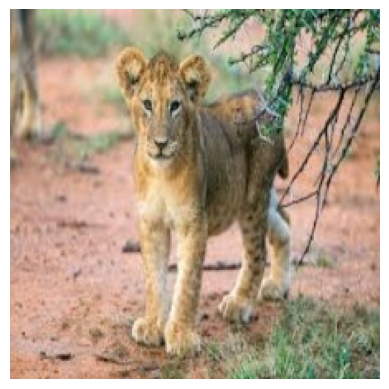

Label index: 11


In [2]:
import matplotlib.pyplot as plt
import numpy as np

def imshow_tensor(image_tensor):
    image = image_tensor.permute(1, 2, 0).numpy()
    image = (image * 0.5) + 0.5  # unnormalize
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Show sample
images, labels = next(iter(train_loader))
imshow_tensor(images[0])
print("Label index:", labels[0].item())


#### **Step 4: Model Definition with ResNet18**

**What Is ResNet?**<br>
ResNet stands for `Residual Network`. It’s a type of deep convolutional neural network (CNN) introduced by Microsoft Research in 2015. It’s famous for solving one of the biggest problems in deep learning: training very deep networks without losing performance.

**🧱 The Problem ResNet Solves**

As you add more layers to a neural network:
- It *should* learn better...  
- But weirdly, it can **start performing worse** (this is called the **degradation problem**)

ResNet fixes that with a simple but powerful trick: **skip connections**.

 **🔁 What Are Skip Connections?**

In a regular CNN, output from one layer goes straight to the next.  
In ResNet, the input is **also added directly to the output** a few layers later.

Like this:

```text
Input → [Layer 1] → [Layer 2] → Output
          ↘____________________↗
              (Skip Connection)
```

This lets the network **“skip” over layers** if needed—kind of like saying:
> “Hey, if these extra layers don’t help, I’ll just ignore them and keep the good stuff flowing.”

This reduces the risk of **vanishing gradients** and makes the model much easier to train.

🐾 **Why We Use ResNet18 for Your Project**

- **18** is the number of layers—not too big, not too small
- Comes **pretrained on ImageNet**, so it already knows a lot about animal features
- We just **replace the last layer** to match your animal classes (14 total)
- Then we “fine-tune” it for your task—it’s **efficient and accurate**, especially with limited data



**What’s the Goal Here?**<br>
- Load a pretrained ResNet18 model from torchvision.models
- Freeze the convolutional backbone (optional for fine-tuning)
- Replace the final classification layer to match your 14 animal classes
- Make it modular and reusable (works in training, inference, app)
<br>

```python
src/
├── split_dataset.py     ← 💾 your dataset organizer (train/val/test)
├── data_loader.py       ← custom Dataset & DataLoader wrapper
├── model.py             ← model definition (e.g. ResNet18)
```


In [3]:
from src.model import get_resnet18

num_classes = 14
model = get_resnet18(num_classes=num_classes, pretrained=True, freeze=True)


C:\Users\DELL\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\DELL\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


#### **Step 5: Training Pipeline with MLflow Integration**

We’ll now create `src/train.py` that will:

- Train your ResNet18 on train_loader
- Evaluate on val_loader after each epoch
- Log hyperparameters and metrics to MLflow
- Save the best-performing model based on validation accuracy

```python
src/
├── split_dataset.py     ← 💾 your dataset organizer (train/val/test)
├── data_loader.py       ← custom Dataset & DataLoader wrapper
├── model.py             ← model definition (e.g. ResNet18)
├── train.py             ← model training logic + MLflow tracking
```

**🧪 Concept: Why Use MLflow?**
<br>
> Think *of MLflow as your training time machine*:
- It logs each experiment—learning rate, batch size, accuracy, model file
- You can compare runs visually, track what’s working, and avoid notebook spaghetti
- We’ll set it up from scratch, no fluff.

In [4]:
from torchvision.datasets import ImageFolder

dataset = ImageFolder('data/processed/train')
print("Detected classes:", dataset.classes)
print("Number of classes:", len(dataset.classes))


Detected classes: ['Bear', 'Bird', 'Cat', 'Cow', 'Deer', 'Dog', 'Dolphin', 'Elephant', 'Giraffe', 'Horse', 'Kangaroo', 'Lion', 'Panda', 'Tiger', 'Zebra']
Number of classes: 15


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import mlflow

from src.model import get_resnet18
from src.train import train_model
from src.data_loader import AlbumentationsDataset
# (and your transforms + loaders from before)

model = get_resnet18(num_classes=15)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.0003)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

mlflow.set_experiment("Animal Classifier")

C:\Users\DELL\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\DELL\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<Experiment: artifact_location='file:///c:/Users/DELL/Desktop/dev/ML/Intership/1Project/mlruns/920278463398720638', creation_time=1750845276740, experiment_id='920278463398720638', last_update_time=1750845276740, lifecycle_stage='active', name='Animal Classifier', tags={}>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import mlflow

from src.model import get_resnet18
from src.train import train_model
from src.data_loader import AlbumentationsDataset
# (and your transforms + loaders from before)

model = get_resnet18(num_classes=15)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.0003)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

mlflow.set_experiment("Animal Classifier")
with mlflow.start_run():
    mlflow.log_param("learning_rate", 0.0003)
    mlflow.log_param("epochs", 10)
    mlflow.log_param("batch_size", 32)

    train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=10)


Once this is running, your logs will appear in a `mlruns/` folder. <br>You can launch MLflow UI with:
```bash
mlflow ui
```
> and visit http://localhost:5000 to visualize all runs.

In `train.py`, after your training loop (and once best_model.pth is saved), you can log it like this

#### **Step 6: Model Evaluation + Metrics Visualization**

Here’s what we’ll build:

- Load best_model.pth
- Predict on the test_loader
- Print a classification report (per-class precision, recall, F1)
- Generate a confusion matrix heatmap
- Log both to MLflow 🎯

```python
src/
├── split_dataset.py     ← 💾 your dataset organizer (train/val/test)
├── data_loader.py       ← custom Dataset & DataLoader wrapper
├── model.py             ← model definition (e.g. ResNet18)
├── train.py             ← model training logic + MLflow tracking
├── evaluate.py          ← test set evaluation + metrics
```

In [6]:
from src.model import get_resnet18
from src.evaluate import evaluate_on_test
import torch

# Load model and weights
model = get_resnet18(num_classes=15)
model.load_state_dict(torch.load("best_model.pth"))
model.to(device)

# Get class names from dataset
from torchvision.datasets import ImageFolder
class_names = ImageFolder("data/processed/train").classes

# Run evaluation
import mlflow

mlflow.set_experiment("Animal Classifier")

with mlflow.start_run():  # 👈 required
    evaluate_on_test(model, test_loader, class_names, device)

C:\Users\DELL\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\DELL\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\DELL\AppData\Local\Temp\ipykernel_20700\3437333716.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.c

              precision    recall  f1-score   support

        Bear       0.95      0.95      0.95        20
        Bird       0.96      1.00      0.98        22
         Cat       1.00      0.95      0.97        19
         Cow       0.90      0.86      0.88        21
        Deer       0.90      0.90      0.90        20
         Dog       0.90      1.00      0.95        19
     Dolphin       1.00      1.00      1.00        20
    Elephant       0.95      1.00      0.98        21
     Giraffe       0.95      1.00      0.98        20
       Horse       0.94      0.85      0.89        20
    Kangaroo       0.90      0.95      0.93        20
        Lion       0.95      0.90      0.93        21
       Panda       1.00      1.00      1.00        21
       Tiger       1.00      1.00      1.00        20
       Zebra       1.00      0.95      0.98        22

    accuracy                           0.95       306
   macro avg       0.95      0.95      0.95       306
weighted avg       0.95   


- **Precision**: Out of all predicted positives, how many were actually correct.  
- **Recall**: Out of all actual positives, how many did the model correctly find.  
- **F1-Score**: The balanced average of precision and recall, especially useful for uneven classes.  
- **Support**: The actual number of true samples for each class in the dataset.

In [ ]:
import plotly.express as px
import pandas as pd
from sklearn.metrics import classification_report
from src.evaluate import evaluate_on_test

y_true, y_pred = evaluate_on_test(model, test_loader, class_names, device)
report_dict = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
df = pd.DataFrame(report_dict).transpose()

# Keep only actual class names (drop averages)
df_classes = df.iloc[:-3].reset_index().rename(columns={'index': 'Class'})

fig = px.bar(
    df_classes,
    x='Class',
    y='f1-score',
    color='f1-score',
    text='f1-score',
    color_continuous_scale='Viridis',
    title='🔍 Per-Class F1 Score (Interactive)',
    labels={'f1-score': 'F1 Score'}
)

fig.update_traces(texttemplate='%{text:.2f}', textposition='outside')
fig.update_layout(
    yaxis=dict(range=[0, 1.05]),
    xaxis_tickangle=-45,
    plot_bgcolor='white',
    font=dict(size=14),
    coloraxis_showscale=False
)

fig.show()



In [ ]:
metrics = ['precision', 'recall', 'f1-score']
df_melted = df.reset_index().melt(id_vars='index', value_vars=metrics, var_name='Metric', value_name='Score')
df_melted.rename(columns={'index': 'Class'}, inplace=True)

fig = px.bar(
    df_melted,
    x='Class',
    y='Score',
    color='Metric',
    barmode='group',
    title='📊 Per-Class Metrics Comparison',
    color_discrete_sequence=px.colors.qualitative.Pastel
)
fig.update_layout(xaxis_tickangle=-45, yaxis_range=[0, 1.05])
fig.show()



In [ ]:
fig = px.scatter(
    df_classes,
    x='precision',
    y='recall',
    size='f1-score',
    hover_name='Class',
    color='f1-score',
    color_continuous_scale='Turbo',
    title='🎯 Precision vs Recall (size = F1 Score)',
    size_max=30
)
fig.update_layout(xaxis=dict(range=[0.7, 1.05]), yaxis=dict(range=[0.7, 1.05]))
fig.show()


In [ ]:
import plotly.graph_objects as go

metrics = ['precision', 'recall', 'f1-score']
colors = ["#6200FF", "#E100FF", "#FF9D00"]  # Blue, Red, Green

fig = go.Figure()

for idx, metric in enumerate(metrics):
    fig.add_trace(go.Scatterpolar(
        r=df_classes[metric],
        theta=df_classes['Class'],
        fill='toself',
        name=metric,
        line=dict(color=colors[idx])
    ))

fig.update_layout(
    polar=dict(radialaxis=dict(visible=True, range=[0, 1.1])),
    title='💠 Radar Plot: Precision, Recall & F1 by Class',
    showlegend=True
)

fig.show()


In [ ]:
# len(class_names)

In [ ]:
# import torch
# from src.model import get_resnet18  # or however you define your architecture

# model = get_resnet18(num_classes=len(class_names))
# model.load_state_dict(torch.load("best_model.pth", map_location="cpu"))
# model.eval()


In [ ]:
# import mlflow
# import mlflow.pytorch
# mlflow.end_run()
# with mlflow.start_run() as run:
#     mlflow.set_tag("stage", "registering model")
#     mlflow.pytorch.log_model(model, artifact_path="model")

#     # Optional: register to the model registry
#     mlflow.register_model(
#         model_uri=f"runs:/{run.info.run_id}/model",
#         name="AnimalClassifierModel"
#     )


#### **Step 7: Inference, Utilities, and Config**

In [7]:
import mlflow.pytorch

model = mlflow.pytorch.load_model("models:/AnimalClassifierModel/1")
model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Add These Three Modules to src/


```python
src/
├── split_dataset.py     ← 💾 your dataset organizer (train/val/test)
├── data_loader.py       ← custom Dataset & DataLoader wrapper
├── model.py             ← model definition (e.g. ResNet18)
├── train.py             ← model training logic + MLflow tracking
├── evaluate.py          ← test set evaluation + metrics
├── inference.py         ← load model + predict on a single image
├── utils.py             ← seed setting, label mapping, etc.
└── config.py            ← paths + hyperparameters
```

In [8]:
from src.config import DEVICE, TEST_DATA_DIR
from src.utils import get_class_names
import mlflow.pytorch

class_names = get_class_names()
model = mlflow.pytorch.load_model("models:/AnimalClassifierModel/1")
model.to(DEVICE)
model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [9]:
from src.data_loader import get_test_loader
test_loader = get_test_loader(data_dir=TEST_DATA_DIR)
with mlflow.start_run(run_name="Notebook Eval on Test"):
    y_true, y_pred = evaluate_on_test(model, test_loader, class_names, device=DEVICE)


              precision    recall  f1-score   support

        Bear       0.17      0.70      0.28        20
        Bird       0.50      0.73      0.59        22
         Cat       0.25      0.42      0.31        19
         Cow       0.83      0.24      0.37        21
        Deer       0.60      0.60      0.60        20
         Dog       0.36      0.68      0.47        19
     Dolphin       1.00      0.55      0.71        20
    Elephant       0.65      0.52      0.58        21
     Giraffe       0.78      0.35      0.48        20
       Horse       1.00      0.45      0.62        20
    Kangaroo       1.00      0.20      0.33        20
        Lion       1.00      0.29      0.44        21
       Panda       0.32      0.29      0.30        21
       Tiger       1.00      0.50      0.67        20
       Zebra       0.79      0.50      0.61        22

    accuracy                           0.47       306
   macro avg       0.68      0.47      0.49       306
weighted avg       0.69   

In [10]:
from src.data_loader import get_test_loader
from src.evaluate import evaluate_on_test

test_loader = get_test_loader(data_dir=TEST_DATA_DIR, batch_size=32)
with mlflow.start_run(run_name="Evaluation from Notebook"):
    y_true, y_pred = evaluate_on_test(model, test_loader, class_names, device=DEVICE)


              precision    recall  f1-score   support

        Bear       0.17      0.70      0.28        20
        Bird       0.50      0.73      0.59        22
         Cat       0.25      0.42      0.31        19
         Cow       0.83      0.24      0.37        21
        Deer       0.60      0.60      0.60        20
         Dog       0.36      0.68      0.47        19
     Dolphin       1.00      0.55      0.71        20
    Elephant       0.65      0.52      0.58        21
     Giraffe       0.78      0.35      0.48        20
       Horse       1.00      0.45      0.62        20
    Kangaroo       1.00      0.20      0.33        20
        Lion       1.00      0.29      0.44        21
       Panda       0.32      0.29      0.30        21
       Tiger       1.00      0.50      0.67        20
       Zebra       0.79      0.50      0.61        22

    accuracy                           0.47       306
   macro avg       0.68      0.47      0.49       306
weighted avg       0.69   

In [14]:
from src.inference import predict_image

image_path = "data/processed/test/Lion/Lion_11_1.jpg"
predicted_class = predict_image(image_path, "models:/AnimalClassifierModel/1", class_names)
print("Predicted:", predicted_class)


Predicted: Dog


In [15]:
from sklearn.metrics import accuracy_score
import torch

# Get one test batch
batch = next(iter(test_loader))
images, labels = batch
images = images.to(DEVICE)
labels = labels.to(DEVICE)

# Predict
with torch.no_grad():
    outputs = model(images)
    preds = outputs.argmax(dim=1)

# Accuracy
acc = accuracy_score(labels.cpu(), preds.cpu())
print(f"Mini-batch accuracy: {acc:.4f}")


Mini-batch accuracy: 0.7500


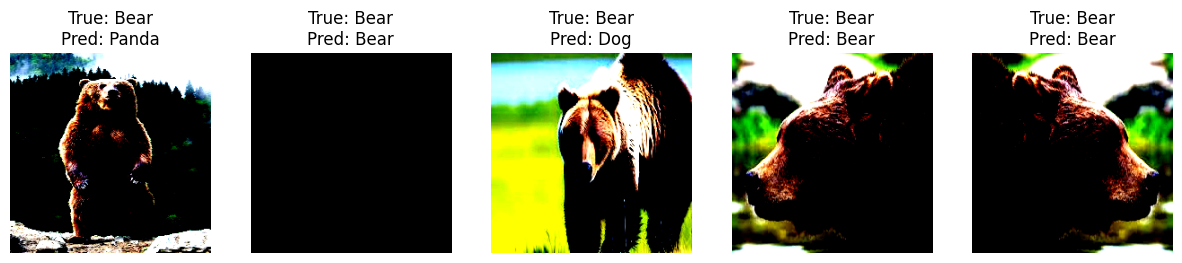

In [ ]:
import matplotlib.pyplot as plt

def show_preds(images, labels, preds, class_names):
    images = images.cpu().permute(0, 2, 3, 1).numpy()
    fig, axs = plt.subplots(1, 5, figsize=(15, 5))
    for i in range(5):
        axs[i].imshow(images[i])
        axs[i].axis("off")
        axs[i].set_title(f"True: {class_names[labels[i]]}\nPred: {class_names[preds[i]]}")

show_preds(images, labels, preds, class_names)


In [20]:
from src.generate_test_report import generate_report

generate_report(
    model_uri="models:/AnimalClassifierModel/1",  # or "Production"/"Staging"
    save_dir="reports"
)


[✓] Accuracy: 0.4673
[✓] Report saved to: reports/


🔍 Classification Report:
              precision    recall  f1-score   support

        Bear       0.17      0.70      0.28        20
        Bird       0.50      0.73      0.59        22
         Cat       0.25      0.42      0.31        19
         Cow       0.83      0.24      0.37        21
        Deer       0.60      0.60      0.60        20
         Dog       0.36      0.68      0.47        19
     Dolphin       1.00      0.55      0.71        20
    Elephant       0.65      0.52      0.58        21
     Giraffe       0.78      0.35      0.48        20
       Horse       1.00      0.45      0.62        20
    Kangaroo       1.00      0.20      0.33        20
        Lion       1.00      0.29      0.44        21
       Panda       0.32      0.29      0.30        21
       Tiger       1.00      0.50      0.67        20
       Zebra       0.79      0.50      0.61        22

    accuracy                           0.47       306
   macro avg       0.68      0.47      0.49       306
w

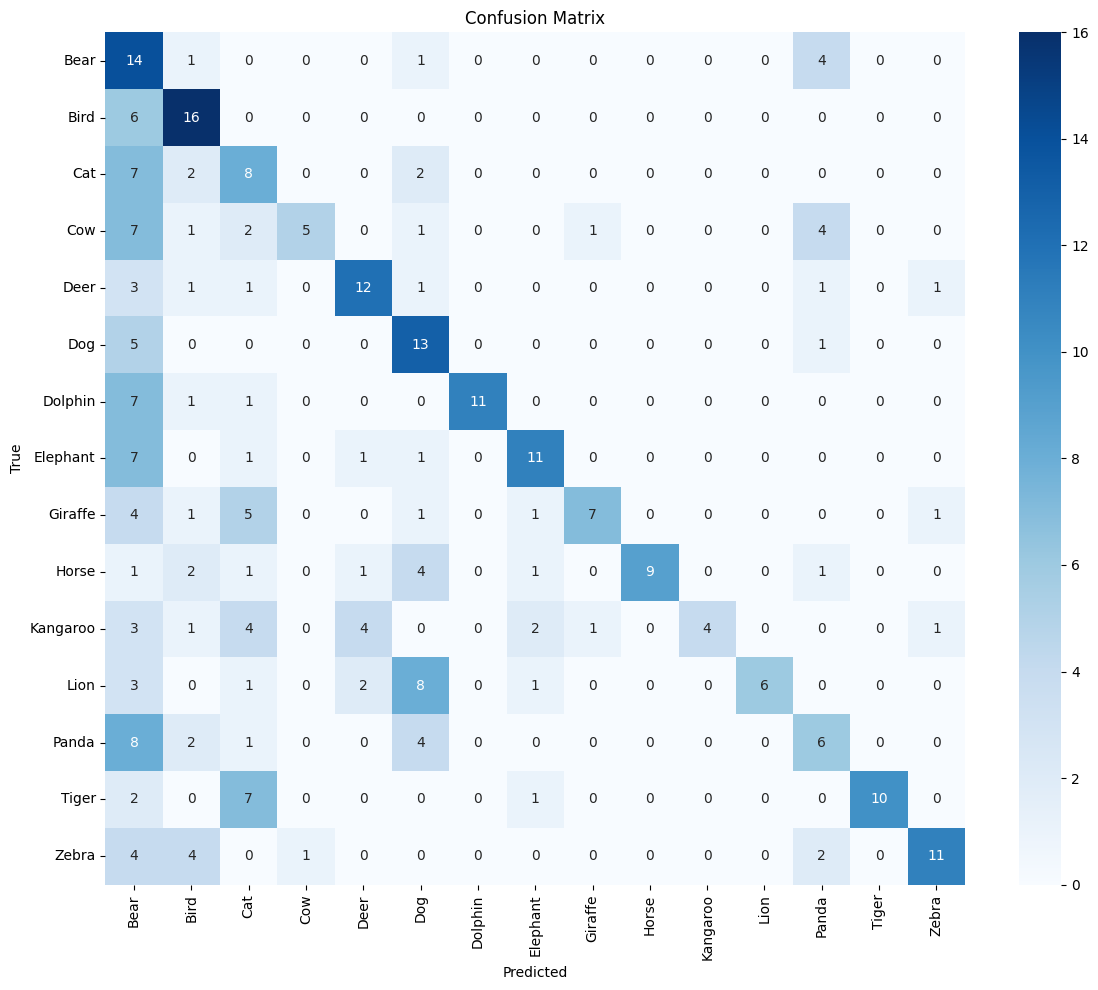

In [21]:
import os
import torch
import mlflow
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from src.config import DEVICE, TEST_DATA_DIR
from src.data_loader import get_test_loader
from src.utils import get_class_names
import mlflow.pytorch

# === Load model from MLflow Registry ===
model_uri = "models:/AnimalClassifierModel/1"  # or "Staging"
model = mlflow.pytorch.load_model(model_uri)
model.to(DEVICE)
model.eval()

# === Get data and class labels ===
test_loader = get_test_loader(TEST_DATA_DIR)
class_names = get_class_names()
y_true, y_pred = [], []

# === Run inference ===
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images.to(DEVICE))
        preds = outputs.argmax(dim=1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# === Compute metrics ===
acc = accuracy_score(y_true, y_pred)
report = classification_report(y_true, y_pred, target_names=class_names)
cm = confusion_matrix(y_true, y_pred)

# === Show results ===
print("🔍 Classification Report:")
print(report)
print(f"\n✅ Overall Accuracy: {acc:.4f}")

# === Plot confusion matrix ===
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()
